In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
# %load_ext nb_black

In [3]:
!cat data/readme.md

# Data

The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

`count` = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

`hate_speech` = number of CF users who judged the tweet to be hate speech.

`offensive_language` = number of CF users who judged the tweet to be offensive.

`neither` = number of CF users who judged the tweet to be neither offensive nor non-offensive.

`class` = class label for majority of CF users.
  0 - hate speech
  1 - offensive  language
  2 - neither


In [4]:
df = pd.read_csv('data/labeled_data.csv')

In [5]:
df.head() 

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


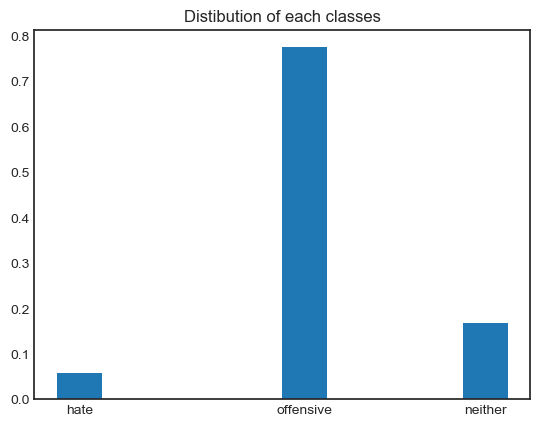

In [6]:
hist, bins_ = np.histogram(df['class'])
freq = hist / np.sum(hist)
plt.bar(bins_[:-1], freq, width=np.diff(bins_))
plt.xticks([0, 1, 1.8], ['hate', 'offensive', 'neither'])
plt.title('Distibution of each classes')
plt.show()

https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language%20Python%203.6.ipynb

In [7]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
import re
# nltk.download()

In [8]:
stemmer = PorterStemmer()

def preprocess(tweet):
    space_pattern = '\s+'
    url_pattern = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_pattern = '@[\w\-]+'
    text = re.sub(space_pattern, ' ', tweet)
    text = re.sub(url_pattern, '', tweet)
    text = re.sub(mention_pattern, '', tweet)
    return text

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [11]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=nltk.corpus.stopwords.words('english'),
    use_idf=True,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)

In [12]:
tweets = df['tweet']
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [18]:
from sklearn.model_selection import train_test_split

X = tfidf
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5)
clf = RandomForestClassifier()

In [15]:
cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1)

array([0.88973554, 0.89060749, 0.88993499, 0.89170404, 0.89058296])

In [20]:
from sklearn.metrics import classification_report

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.26      0.33       290
           1       0.93      0.94      0.94      3832
           2       0.79      0.85      0.82       835

    accuracy                           0.89      4957
   macro avg       0.72      0.68      0.70      4957
weighted avg       0.88      0.89      0.88      4957



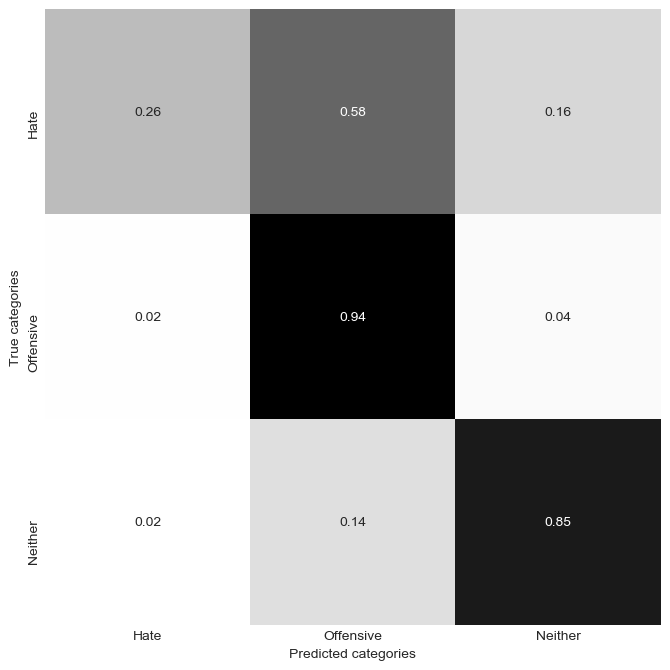

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = confusion_matrix(y_test, y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names = ['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_df, annot=True,annot_kws={"size": 10},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel('True categories', fontsize=10)
plt.xlabel('Predicted categories', fontsize=10)
plt.tick_params(labelsize=10)
# plt.savefig('rf_base_model.png')
plt.show()